In [ ]:
'''
 GS 2024 IA  Integrantes
94696 - Arthur De Pieri Soares
94108 -  Gustavo Vitoti Fernandes Ribeiro
93005 - Vinícius Mergl Margonari

'''

'\n GS 2024 IA  Integrantes\n94696 - Arthur De Pieri Soares\n94108 -  Gustavo Vitoti Fernandes Ribeiro\n93005 - Vinícius Mergl Margonari\n\n'

In [ ]:
# Importando bibliotecas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")


# Carregar o dataset (ajuste o caminho para o arquivo)
file_path = 'Dataset 1_EV charging reports.csv'  # Substitua pelo caminho correto
df = pd.read_csv(file_path, delimiter=';')

# Pré-processamento inicial
df['El_kWh'] = df['El_kWh'].str.replace(',', '.').astype(float)
df['Duration_hours'] = df['Duration_hours'].str.replace(',', '.').astype(float)

# Convertendo colunas de data e hora
df['Start_plugin'] = pd.to_datetime(df['Start_plugin'], format='%d.%m.%Y %H:%M', errors='coerce')
df['End_plugout'] = pd.to_datetime(df['End_plugout'], format='%d.%m.%Y %H:%M', errors='coerce')

# Calculando duração das sessões de carregamento e preenchendo valores ausentes
df['Calculated_Duration'] = (df['End_plugout'] - df['Start_plugin']).dt.total_seconds() / 3600
df['Duration_hours'].fillna(df['Calculated_Duration'], inplace=True)
df.drop(columns=['Calculated_Duration'], inplace=True)

# Removendo linhas com valores ausentes em 'Duration_hours'
df.dropna(subset=['Duration_hours'], inplace=True)

# Criando variáveis temporais
df['Hour_of_day'] = df['Start_plugin'].dt.hour
df['Day_of_week'] = df['Start_plugin'].dt.dayofweek
df['Month'] = df['Start_plugin'].dt.month

# Target para demanda (quantidade de sessões em cada horário)
df['Demand'] = df.groupby(['Day_of_week', 'Month', 'Hour_of_day'])['Duration_hours'].transform('size')

# Definindo as variáveis de entrada e as saídas para duração, demanda e custo
features = df[['Hour_of_day', 'Day_of_week', 'Month', 'El_kWh']]
target_duration = df['Duration_hours']
target_demand = df['Demand']
target_cost = target_demand * target_duration * df['El_kWh']

# Dividindo os dados em treino e teste
X_train, X_test, y_duration_train, y_duration_test, y_demand_train, y_demand_test, y_cost_train, y_cost_test = train_test_split(
    features, target_duration, target_demand, target_cost, test_size=0.2, random_state=42
)

# Normalizando os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


<ipython-input-48-7809ebef5b89>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Duration_hours'].fillna(df['Calculated_Duration'], inplace=True)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Construindo o modelo de rede neural
input_layer = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(input_layer)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)

# Saídas para duração, demanda e custo
output_duration = Dense(1, name="duration_output")(x)
output_demand = Dense(1, name="demand_output")(x)
output_cost = Dense(1, name="cost_output")(x)

# Criando o modelo com múltiplas saídas
model = Model(inputs=input_layer, outputs=[output_duration, output_demand, output_cost])

# Compilando o modelo com métricas e perdas específicas para cada saída
model.compile(
    optimizer='adam',
    loss={'duration_output': 'mse', 'demand_output': 'mse', 'cost_output': 'mse'},
    metrics={'duration_output': 'mae', 'demand_output': 'mae', 'cost_output': 'mae'}
)

# Treinando o modelo
history = model.fit(
    X_train,
    {'duration_output': y_duration_train, 'demand_output': y_demand_train, 'cost_output': y_cost_train},
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    verbose=1
)

Epoch 1/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - cost_output_mae: 1906.3560 - demand_output_mae: 12.2247 - duration_output_mae: 11.1265 - loss: 19915632.0000 - val_cost_output_mae: 1904.7673 - val_demand_output_mae: 13.1137 - val_duration_output_mae: 8.7946 - val_loss: 15661120.0000
Epoch 2/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cost_output_mae: 1941.3530 - demand_output_mae: 9.9039 - duration_output_mae: 11.5467 - loss: 26153424.0000 - val_cost_output_mae: 1648.4358 - val_demand_output_mae: 8.4684 - val_duration_output_mae: 8.2216 - val_loss: 13457805.0000
Epoch 3/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cost_output_mae: 1763.1771 - demand_output_mae: 8.1460 - duration_output_mae: 8.4543 - loss: 21610260.0000 - val_cost_output_mae: 1650.2750 - val_demand_output_mae: 8.5497 - val_duration_output_mae: 8.3703 - val_loss: 9705246.0000
Epoch 4/150
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - cost_output_mae: 1756.1437 - demand_output_mae: 8.1057 - duration_output_mae: 7.8138 - l

In [ ]:
# Avaliando o modelo no conjunto de teste
y_duration_pred, y_demand_pred, y_cost_pred = model.predict(X_test)

# Calculando métricas para a previsão de duração
mae_duration = mean_absolute_error(y_duration_test, y_duration_pred)
rmse_duration = np.sqrt(mean_squared_error(y_duration_test, y_duration_pred))
print(f"MAE (Duração): {mae_duration}")
print(f"RMSE (Duração): {rmse_duration}")

# Calculando métricas para a previsão de demanda
mae_demand = mean_absolute_error(y_demand_test, y_demand_pred)
rmse_demand = np.sqrt(mean_squared_error(y_demand_test, y_demand_pred))
print(f"MAE (Demanda): {mae_demand}")
print(f"RMSE (Demanda): {rmse_demand}")

# Calculando métricas para a previsão de custo
mae_cost = mean_absolute_error(y_cost_test, y_cost_pred)
rmse_cost = np.sqrt(mean_squared_error(y_cost_test, y_cost_pred))
print(f"MAE (Custo): {mae_cost}")
print(f"RMSE (Custo): {rmse_cost}")


43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAE (Duração): 8.453309915001684
RMSE (Duração): 12.713817230167225
MAE (Demanda): 5.179843067687475
RMSE (Demanda): 7.963350734698746
MAE (Custo): 1319.2721354504167
RMSE (Custo): 3287.2885130960362


In [ ]:
# Definindo tarifas por hora para as 24 horas do dia
tarifas = {
    0: 0.12, 1: 0.10, 2: 0.10, 3: 0.10, 4: 0.11, 5: 0.11,
    6: 0.13, 7: 0.14, 8: 0.15, 9: 0.15, 10: 0.14, 11: 0.13,
    12: 0.13, 13: 0.12, 14: 0.12, 15: 0.11, 16: 0.10, 17: 0.10,
    18: 0.12, 19: 0.13, 20: 0.14, 21: 0.15, 22: 0.15, 23: 0.15
}

def suggest_optimal_charging_time(day_of_week, month, scaler, model):
    min_cost = float('inf')
    best_hour = None

    for hour in range(24):
        input_data = scaler.transform([[hour, day_of_week, month, 0]])
        predicted_duration, predicted_demand, predicted_cost = model.predict(input_data)

        # Cálculo do custo ajustado pela tarifa horária
        cost = predicted_cost[0] * tarifas[hour]

        if cost < min_cost:
            min_cost = cost
            best_hour = hour

    return best_hour, min_cost

# Exemplo de uso:
# Sugerindo o melhor horário de carregamento para uma segunda-feira de janeiro
best_hour, min_cost = suggest_optimal_charging_time(day_of_week=0, month=1, scaler=scaler, model=model)
print(f"Melhor horário de carregamento: {best_hour}:00 com custo estimado de ${float(min_cost):.2f}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Melhor horário de carregamento: 3:00 com custo estimado de $6.92


<ipython-input-67-a85d37c6f4a9>:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Melhor horário de carregamento: {best_hour}:00 com custo estimado de ${float(min_cost):.2f}")


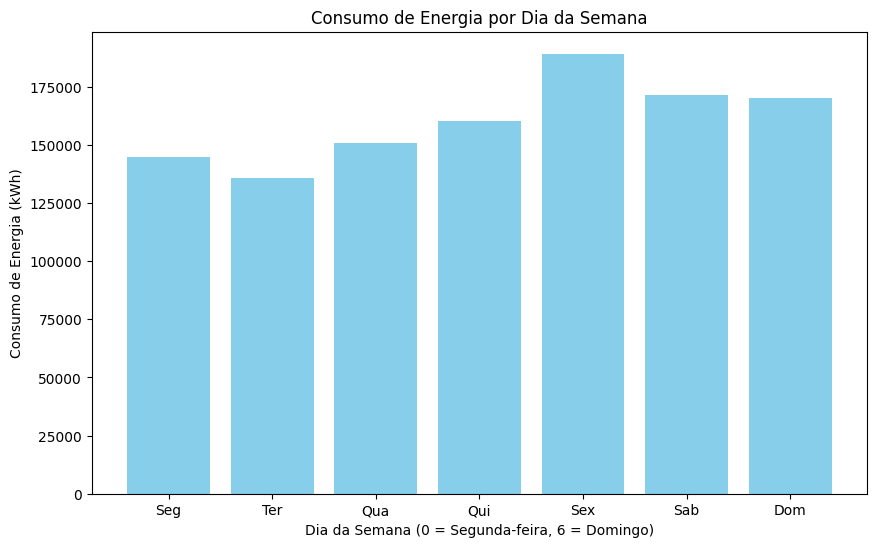

In [ ]:
import matplotlib.pyplot as plt

# Calculando o consumo de energia por dia da semana
df['Energy_Consumption'] = df['Duration_hours'] * df['El_kWh']  # Consumo total por sessão
energy_by_day = df.groupby('Day_of_week')['Energy_Consumption'].sum()

# Exibindo o gráfico
plt.figure(figsize=(10, 6))
plt.bar(energy_by_day.index, energy_by_day.values, color='skyblue')
plt.title("Consumo de Energia por Dia da Semana")
plt.xlabel("Dia da Semana (0 = Segunda-feira, 6 = Domingo)")
plt.ylabel("Consumo de Energia (kWh)")
plt.xticks(ticks=range(7), labels=["Seg", "Ter", "Qua", "Qui", "Sex", "Sab", "Dom"])
plt.show()


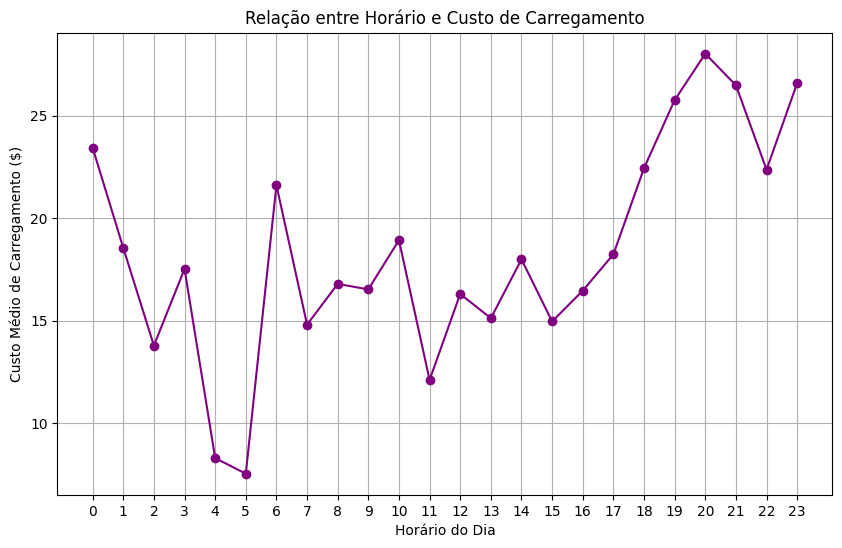

In [ ]:
# Definindo tarifas por hora para as 24 horas do dia (exemplo)
tarifas = {
    0: 0.12, 1: 0.10, 2: 0.10, 3: 0.10, 4: 0.11, 5: 0.11,
    6: 0.13, 7: 0.14, 8: 0.15, 9: 0.15, 10: 0.14, 11: 0.13,
    12: 0.13, 13: 0.12, 14: 0.12, 15: 0.11, 16: 0.10, 17: 0.10,
    18: 0.12, 19: 0.13, 20: 0.14, 21: 0.15, 22: 0.15, 23: 0.15
}

# Calculando o custo estimado por horário
df['Cost'] = df['Energy_Consumption'] * df['Hour_of_day'].map(tarifas)
cost_by_hour = df.groupby('Hour_of_day')['Cost'].mean()

# Exibindo o gráfico
plt.figure(figsize=(10, 6))
plt.plot(cost_by_hour.index, cost_by_hour.values, marker='o', color='purple')
plt.title("Relação entre Horário e Custo de Carregamento")
plt.xlabel("Horário do Dia")
plt.ylabel("Custo Médio de Carregamento ($)")
plt.xticks(ticks=range(24))
plt.grid()
plt.show()
